In [1]:
import sys
import tqdm
import time
import sklearn
import numpy as np
import pandas as pd
import scipy
import copy
import random
import math
import torch
import torch.nn.functional as F
# from load_dataset import load
# from classifier import NeuralNetwork, LogisticRegression, SVM
# from utils import *
# from metrics import *  # include fairness and corresponding derivatives
from scipy import stats
from scipy.stats import rankdata
from sklearn import metrics, preprocessing
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report
from sklearn.svm import SVC, LinearSVC
from torch.autograd import grad
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display
random.seed(1)
np.random.seed(1)
# torch.manual_seed(1)

**Deviations**

In [10]:
deviation_first = [0.07486852086156526, 0.008266881447066776, 0.0523114501363691, 0,\
                   0.06832253491460855, 0.0077469567908597554, 0.036652404785604706, 0,\
                   0.02825151460556667, 0.0035289185235499146, 0.02778803444600452]
deviation_second = [0.07252584006983792, 0.006497057812035012, 0.03177450457021214, 0,\
                   0.06279976508585587, 0.006363963973930674, 0.016235626987723538, 0,\
                   0.025088686553197022, 0.0027894406347749845, 0.030031577838027526]
deviation_gd = [0.04381598649197255, 0.012651122449561413, 0.02186822880062204, 0,\
               0.058911984027377594, 0.01111616811178203, 0.021206519135692936, 0,\
               0.01329056191214062, 0.003347789695758036, 0.024944172812137594]

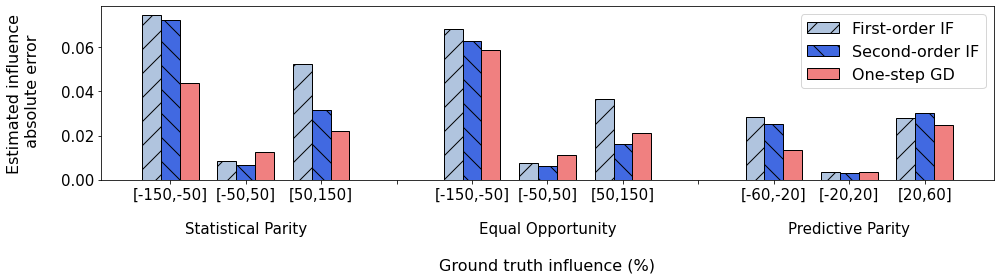

In [108]:
plt.figure(figsize=(14,4))
width = 0.25
alpha = 0.6
bin_num = 3

edge_color = np.zeros((bin_num, 4))
edge_color[:, 3] = 1.0 # alpha
edge_width = 1

bar_color_first = np.zeros((bin_num, 4))
bar_color_first[:, 2] = 1.0 # blue
bar_color_first[:, 3] = 0.2 # alpha

bar_color_second = np.zeros((bin_num, 4))
bar_color_second[:, 2] = 1.0 # blue
bar_color_second[:, 3] = 0.7 # alpha

bar_color_gd = np.zeros((bin_num, 4))
bar_color_gd[:, :1] = 1.0 # :3 yellow
bar_color_gd[:, 3] = 0.5 # alpha

index = np.arange(bin_num*3+2)
plt.bar(index-width, deviation_first, width, label='First-order IF', color='lightsteelblue',\
        linewidth=edge_width, edgecolor=edge_color, hatch='/')
plt.bar(index, deviation_second, width, label='Second-order IF', color='royalblue',\
       linewidth=edge_width, edgecolor=edge_color, hatch='\\')
plt.bar(index+width, deviation_gd, width, label='One-step GD', color='lightcoral',\
       linewidth=edge_width, edgecolor=edge_color)
ticks_1 = [f'[{(2*bin_id-3)*50},{(2*bin_id-1)*50}]' for bin_id in range(bin_num)]
ticks_1[1] += '\n\nStatistical Parity'
ticks_2 = [f'[{(2*bin_id-3)*50},{(2*bin_id-1)*50}]' for bin_id in range(bin_num)]
ticks_2[1] += '\n\nEqual Opportunity'
ticks_3 = [f'[{(2*bin_id-3)*20},{(2*bin_id-1)*20}]' for bin_id in range(bin_num)]
ticks_3[1] += '\n\nPredictive Parity'
# print(ticks_1)
# print(ticks_2)
# print(ticks_3)
plt.xticks(range(bin_num*3+2), ticks_1 + [''] + ticks_2 + [''] + ticks_3, rotation=0, fontsize=15)
plt.yticks(np.arange(0, 0.08, .02), fontsize=15)
# plt.grid()
plt.ylabel('Estimated influence\n absolute error\n', fontsize=16)
# , fontweight='bold')
plt.xlabel('\nGround truth influence (%)',\
           fontsize=16)
#            , fontweight='bold')
# plt.legend(fontsize=12, prop={'weight':'bold'})
plt.legend(fontsize=16)
plt.tight_layout()
# plt.show()
plt.savefig('effectiveness.pdf', dpi=150)

**Time**

In [2]:
time_first = [0.0004, 0.0008, 0.001, 0.0015, 0.0018, 0.003, 0.0028, 0.003, 0.0035, 0.0038]
time_second = [0.0005, 0.001, 0.0018, 0.002, 0.0024, 0.0038, 0.004, 0.0044, 0.005, 0.0052]
time_gt = [0.0082, 0.0082, 0.008, 0.0078, 0.0078, 0.0076, 0.007, 0.0064, 0.0064, 0.006]
time_gd = [0.013, 0.012, 0.0136, 0.012, 0.0128, 0.0116, 0.011, 0.0108, 0.011, 0.0116]

time_first = [ele * 1000 for ele in time_first]
time_second = [ele * 1000 for ele in time_second]
time_gd = [ele * 1000 for ele in time_gd]
time_gt = [ele * 1000 for ele in time_gt]

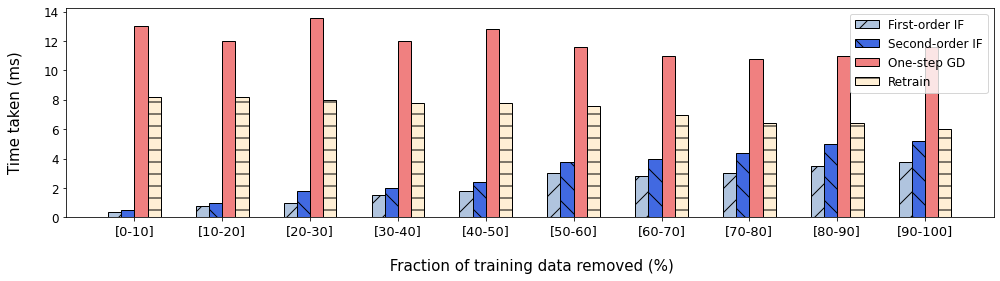

In [3]:
plt.figure(figsize=(14,4))
bin_num = 10
bins_gt = []
bins_gd = []
bins_first = []
bins_second = []
# alpha = 0.7

# for bin_id in range(bin_num):
#     gt_time_in_bin = np.array(gt_ys).copy()
#     first_time_in_bin = np.array(first_ys).copy()
#     second_time_in_bin = np.array(second_ys).copy()
#     gd_time_in_bin = np.array(gd_ys).copy()
#     gt_xs = np.array(gt_xs)

#     in_bin_idx = (gt_xs>=bin_id*10)&(gt_xs<(bin_id+1)*10)
    
#     gt_time_in_bin = gt_time_in_bin[in_bin_idx]
#     first_time_in_bin = first_time_in_bin[in_bin_idx]
#     second_time_in_bin = second_time_in_bin[in_bin_idx]
#     gd_time_in_bin = gd_time_in_bin[in_bin_idx]
    
#     bins_gt.append(gt_time_in_bin)
#     bins_first.append(first_time_in_bin)
#     bins_second.append(second_time_in_bin)
#     bins_gd.append(gd_time_in_bin)

edge_color = np.zeros((bin_num, 4))
edge_color[:, 3] = 1.0 # alpha
edge_width = 1

bar_color_first = np.zeros((bin_num, 4))
bar_color_first[:, 2] = 1.0 # blue
bar_color_first[:, 3] = 0.3 # alpha

bar_color_second = np.zeros((bin_num, 4))
bar_color_second[:, 2] = 1.0 # blue
bar_color_second[:, 3] = 0.7 # alpha

bar_color_gt = np.zeros((bin_num, 4))
bar_color_gt[:, 0] = 61/255
bar_color_gt[:, 1] = 145/255
bar_color_gt[:, 2] = 64/255
bar_color_gt[:, 3] = 1.0 # alpha

bar_color_gd = np.zeros((bin_num, 4))
bar_color_gd[:, :2] = 1.0 # yellow
bar_color_gd[:, 3] = 0.5 # alpha

width = 0.15
index = np.arange(bin_num)
plt.bar(index-3*width/2, time_first,
        width, label='First-order IF', color='lightsteelblue', hatch='/', linewidth=edge_width, edgecolor=edge_color)
plt.bar(index-width/2, time_second,
        width, label='Second-order IF', color='royalblue', hatch='\\', linewidth=edge_width, edgecolor=edge_color)
plt.bar(index+width/2, time_gd,
        width, label='One-step GD', color='lightcoral', linewidth=edge_width, edgecolor=edge_color)
plt.bar(index+3*width/2, time_gt,
        width, label='Retrain', color='papayawhip', hatch='-', linewidth=edge_width, edgecolor=edge_color)


plt.xticks(range(bin_num), [f'[{bin_id*10}-{(bin_id+1)*10}]' for bin_id in range(bin_num)], fontsize=13, rotation=0)
plt.yticks(fontsize=12)
plt.legend(loc='upper right', fontsize=12)
# , prop={'weight':'bold'})
# plt.grid()
plt.tight_layout()
# plt.title('Comparison on time cost (german)', fontsize=16, fontweight='bold')
plt.xlabel('\n Fraction of training data removed (%)', fontsize=15)
# , fontweight='bold')
plt.ylabel('Time taken (ms)\n', fontsize=15)
# , fontweight='bold')
plt.tight_layout()
# plt.show()
plt.savefig('time.pdf', dpi=150)